##### Copyright 2018 The TensorFlow Authors.

# Basic classification: Predict an image of clothing
Ramesh Yerraballi for MIS 285N
Derived from [https://www.tensorflow.org/tutorials/keras/classification](https://www.tensorflow.org/tutorials/keras/classification)

_quote_ "This guide trains a neural network model to classify images of clothing, like sneakers and shirts. 
This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow." _unquote_

In this notebook we will solve the classification problem on a CPU and GPU for comparison. Look for the another notebook that solves the problem on a TPU

In [40]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.6.0


In [41]:
devs =tf.config.experimental.list_physical_devices()
print(devs)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [124]:
# Check if GPU is being used
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import the  MNIST dataset

In [43]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [44]:
class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five',
               'Six', 'Seven', 'Eight', 'Nine']

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set, with each image represented as 28 x 28 pixels:

In [45]:
train_images.shape

(60000, 28, 28)

Likewise, there are 60,000 labels in the training set:

In [46]:
len(train_labels)

60000

Each label is an integer between 0 and 9:

In [47]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 28 x 28 pixels:

In [48]:
test_images.shape

(10000, 28, 28)

And the test set contains 10,000 images labels:

In [49]:
len(test_labels)

10000

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

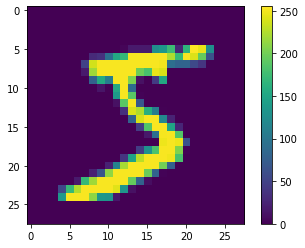

In [50]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [51]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [52]:
train_images = tf.cast(train_images, tf.float32)/ 255.0

test_images = tf.cast(test_images, tf.float32) / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

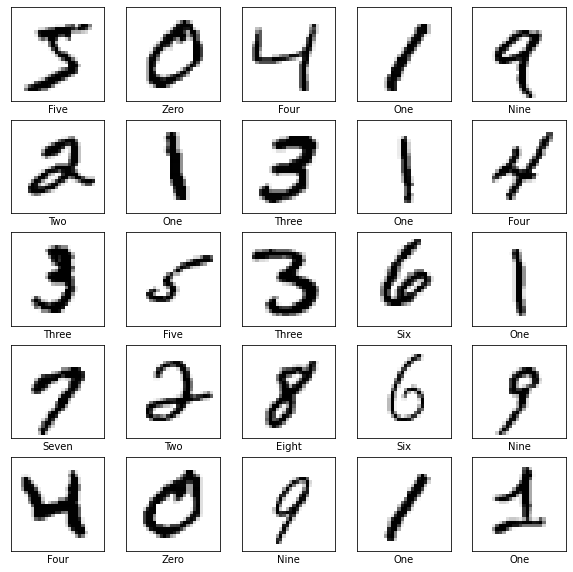

In [53]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the *layer*. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

In [54]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer is a 10-node *softmax* layer that returns an array of 10 probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's *compile* step:

* [Loss function](https://keras.io/api/losses/) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [Optimizer](https://keras.io/api/optimizers/) —This is how the model is updated based on the data it sees and its loss function.
* [Metrics](https://keras.io/api/metrics/) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [55]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


* **optimizer used**: [adam](https://keras.io/api/optimizers/adam/) is a stochastic gradient descent method. According to Kingma et al., 2014, the method is "computationally efficient, has little memory requirement, invariant to diagonal rescaling of gradients, and is well suited for problems that are large in terms of data/parameters".

* **loss function used**: [sparse_categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class) is typically used when there are two or more label classes. It expects labels to be provided as integers.

* **metric used**: [accuracy](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class) calculates how often predictions equal labels.



## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array. Verify that the predictions match the labels from the `test_labels` array.

To start training,  call the `model.fit` method—so called because it "fits" the model to the training data:

We will do three different cells here as running the fit is different for each of the three cases:
1. On CPU
2. On GPU
3. On TPU (look for another notebook)

The first one will be on CPU. As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.91 (or 91%) on the training data. Note that the keras sequential module automatically batches the data into default of 32 samples per batch. The number 1875 in the output below is from 60000/32 = 1875

In [56]:
%%time
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2660 - accuracy: 0.9229
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1134 - accuracy: 0.9665
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0772 - accuracy: 0.9762
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0587 - accuracy: 0.9821
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0461 - accuracy: 0.9859
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0354 - accuracy: 0.9890
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0283 - accuracy: 0.9916
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0232 - accuracy: 0.9924
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0182 - accuracy: 0.9943
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.016

In [80]:
# Check if GPU is being used
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [81]:
with tf.device('/device:GPU:0'):
  gmodel = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
  gmodel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [82]:
%%time
with tf.device('/device:GPU:0'):

  gmodel.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2603 - accuracy: 0.9241
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1157 - accuracy: 0.9659
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0778 - accuracy: 0.9769
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0586 - accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0462 - accuracy: 0.9855
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0351 - accuracy: 0.9892
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0286 - accuracy: 0.9914
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0234 - accuracy: 0.9931
Epoch 9/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0188 - accuracy: 0.9944
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.015

## Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [84]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('\nTest accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0850 - accuracy: 0.9773

Test accuracy: 0.9772999882698059


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting is when a machine learning model performs worse on new, previously unseen inputs than on the training data.

## Make predictions

With the model trained, you can use it to make predictions about some images.

In [85]:
predictions = model.predict(test_images)

Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [88]:
predictions[0]

array([4.6707305e-09, 3.2463945e-11, 1.4149748e-08, 4.2453172e-05,
       7.9176235e-15, 7.7293609e-11, 1.0154569e-14, 9.9995732e-01,
       8.4759462e-09, 2.2571470e-07], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [86]:
np.argmax(predictions[0])

7

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [87]:
test_labels[0]

7

Graph this to look at the full set of 10 class predictions.

In [96]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

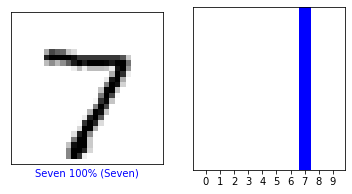

In [97]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

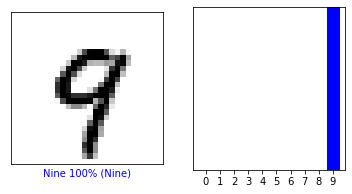

In [98]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

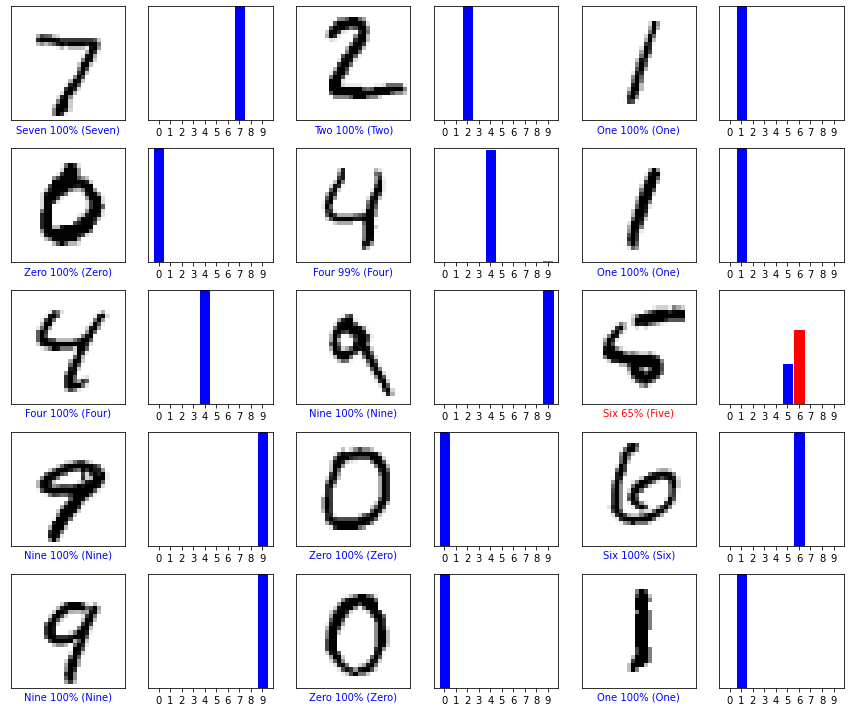

In [99]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

The first 15 bad predictions again with the image and the histogram



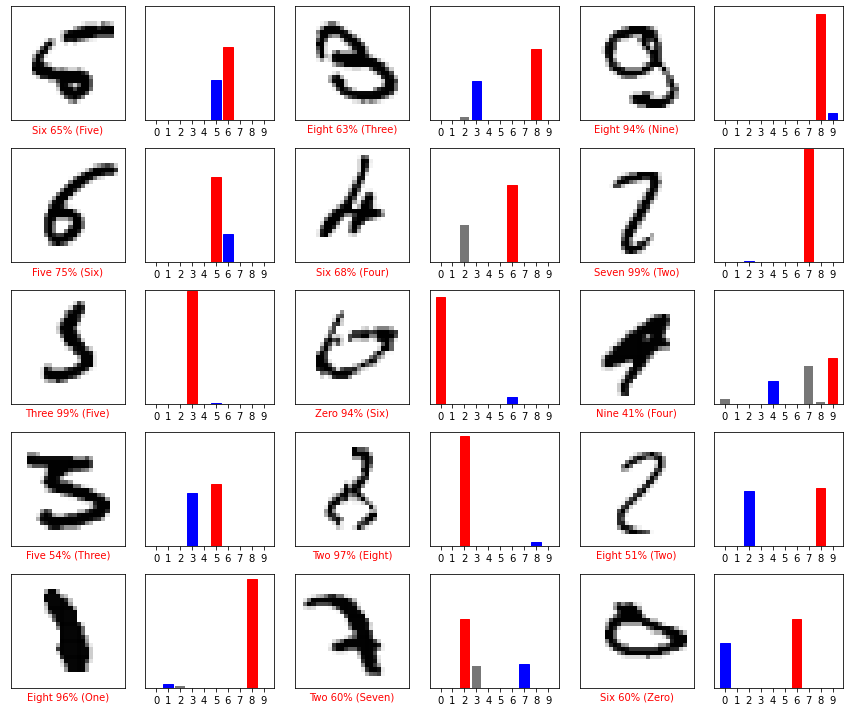

In [108]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
'''incorrect_indexes = []
incorrect_pred = []
incorrect_label = []
incorrect_image = []

while j < num_images:
  index = 0
  if predictions[index] != test_labels[index]:
    incorrect_pred.append(predictions[index])
    incorrect_indexes.appned(index)
    j = j + 1
    index = index + 1
  else:
    index = index + 1'''

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
j = 0
i = 0
while j < num_images:
  predicted_label = np.argmax(predictions[i])

  if predicted_label != test_labels[i]:
    plt.subplot(num_rows, 2*num_cols, 2*j+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*j+2)
    plot_value_array(i, predictions[i], test_labels)
    j = j + 1
  i = i + 1
plt.tight_layout()
plt.show()

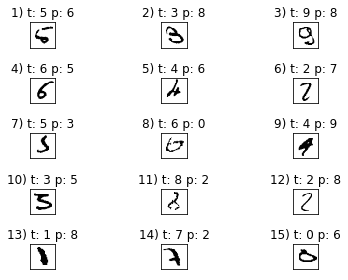

In [123]:
#Plot 3  predictions[i], test_labels, test_images   predicted_label = np.argmax(predictions[i])

pred_label = np.argmax(predictions, axis = 1)
miscl_img = test_images[test_labels != pred_label][:25]
correct_lab = test_labels[test_labels != pred_label][:25]
miscl_lab = pred_label[test_labels != pred_label][:25]

fig, ax = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(15):
    img = miscl_img[i]
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.savefig('misses.png', dpi=300)
plt.show()